### Predicting Continuous Target Variables with Regression Analysis

In [286]:
import pandas as pd 
import sys 
import matplotlib.pyplot as plt 
from mlxtend.plotting import scatterplotmatrix
import numpy as np
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#### Import the dataset, define columns, and view several rows and columns of the datatset

In [287]:
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

In [288]:
df = pd.read_csv(r'C:\Users\S\Desktop\import\AmesHousing.txt',sep='\t', usecols=columns)

In [289]:
df.head()


,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


### Quick view of data to confirm number of rows

In [290]:
df.shape

(2930, 6)

In [291]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

### Data Prep and Cleaning

#### Checking for any missing values

In [292]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

#### A missing value found in Bsmt SF will be removed using  the dropna() method

In [293]:
df = df.dropna(axis=0) 
# then confirm by rechecking missing values
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

### Visualizing Important aspects of the Dataset using a scatterplot matrix

scatterplotmatrix(df.values, figsize=(12, 10), 
                  names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

### Examining relationships using a correlation matrix

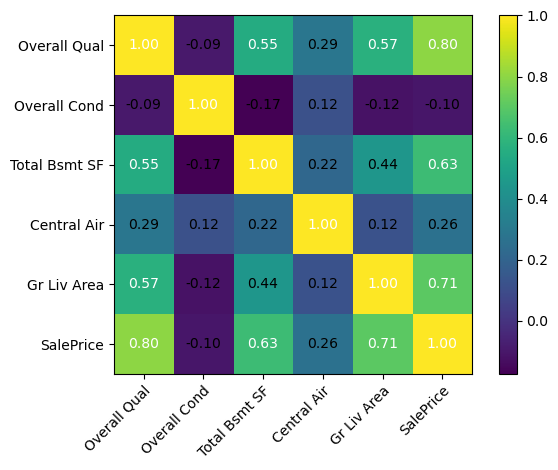

In [294]:
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns) # from mlxtend.plotting lib

plt.tight_layout()
plt.show()

### Implementing an Ordinary Least Squares Regression Model,and solving for regression parameters with  Gradient Descent

#### Rational: OLS (ordinary Least Squares or Linear least Squares) is used here to estimate the parameters of the regression line that minimizes the sum  of squared vertical distances (the residuals or errors) in the training example.

In [295]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

In [296]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

In [297]:
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [298]:
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

### Plotting the Loss as a function of the number of Epochs (complete iterations) over the training set to check that convergence to a loss-minimum has occurred.

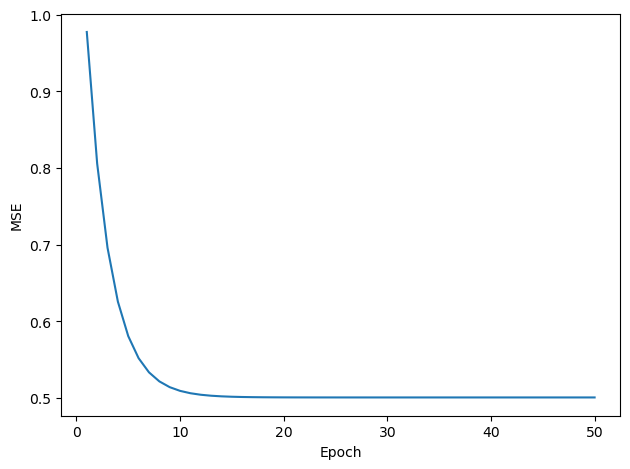

In [299]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()


### Visualizing the regression line fit (plotting sale prce as a function of living area)

In [300]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

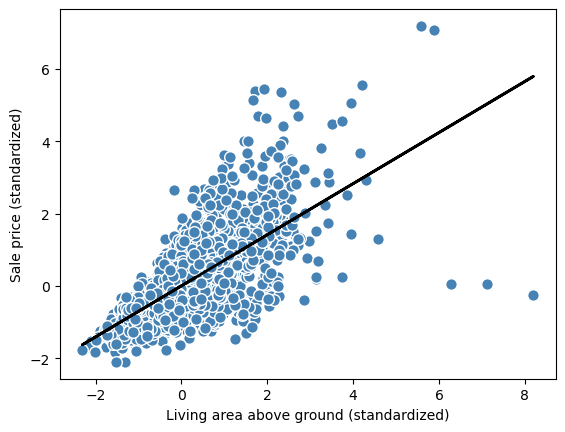

In [301]:
lin_regplot(X_std, y_std, lr) # using lin_regplot() to plot sale price as a function of living area
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

plt.show()


#### The above graph is not giving a full picture on the relationship between price and living area. To attempt at greater insight, the inverse_transform method of StandardScaler will be applied to report the predicted outcome variables on their original scale.

In [302]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


### Confirming that we are indeed working with standardized variables (since the y intercept will be zero in those cases)

In [303]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


#### Using Some FORTRAN (*because it rocks*) libraries in ScikitLearn to solve some linear algebra (LAPACK libs).

In [304]:
slr = LinearRegression()
slr.fit(X, y) 
y_pred = slr.predict(X) 
print(f'Slope: {slr.coef_[0]:.3f}') 


Slope: 111.666


In [305]:
print(f'Intercept: {slr.intercept_:.3f}')

Intercept: 13342.979


#### Using the LAPACK libs was not merely an excuse to make use of a better programming language, but rather because those LAPACK (Linear Algebra Package) works better with unstandardized variables, such as what we are dealing with here. 

### Note: When viewing the model coefficients we see that they differ (because the features have not been standardized), however if we plot the regression performed using the Fortran libraries, we see that indeed the graphs correspond quite well in their data fitting.

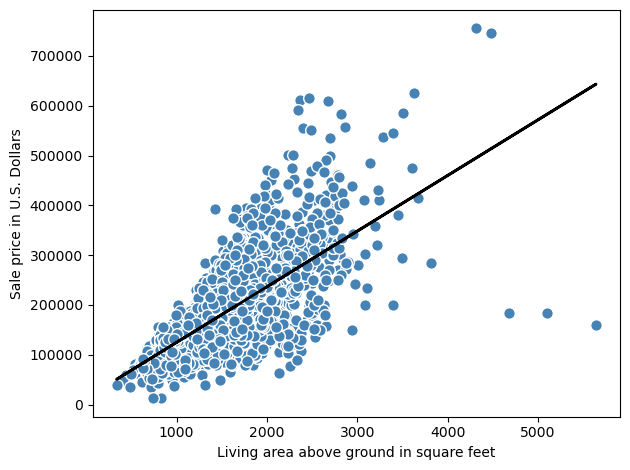

In [306]:
lin_regplot(X, y, slr) 
plt.xlabel('Living area above ground in square feet') 
plt.ylabel('Sale price in U.S. Dollars') 
plt.tight_layout() 
plt.show()

### An alternative solution to using ML libraries can be done using by coding  w = (X^T X)^-1 X^Ty) , which is a closed-form solution for solinv Ordinary Least Sqaures(OLS)

In [307]:
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print(f'Slope: {w[1]:.3f}')
print(f'Intercept: {w[0]:.3f}')

Slope: 111.666
Intercept: 13342.979


#### Note: The above method works fine for small data sets, but when things get computationally serious, Fortran /LAPACK are your friends.

## Dealing with Outliers using the RANSAC (Random Sample Consensus) algorithm

### As mentioned previously, the graphs did not appear to give as granular representation of the sales price and living area relationship as desired. To deal with potential outliers in the dataset that might be skewing the results we can to hopefully account for any outliers present.The RANSAC algorithm does this by using a subset of the data, the so called "inliers" as opposed to removing suspected outliers in the data. This approach can be preferable to removing data points , for example when insufficient domain knowledge of the dataset in question for determinging outlier classification is the case.


### General RANSAC algorithm iterative process: 
<ul><li>1. Select a random number of examples to be inliers and fit the model.</li>
<li>2. Test all other data points against the fitted model and add those points that fall within a user-given tolerance to inliers.</li>
<li>3. Refit the model using all inliers.</li>
<li>4. Estimate the error of the fitted model versus the inliers.</li>
<li>5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a fixed number of iterations was reached; go back to step 1 otherwise.</li>
</ul>

(from the scikitlearn docs): RANSAC is a non-deterministic algorithm producing only a reasonable result with a certain probability, which is dependent on the number of iterations (see max_trials parameter). It is typically used for linear and non-linear regression problems and is especially popular in the field of photogrammetric computer vision.

In [308]:
ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100,          # default value
                         min_samples=0.95, 
                         loss='absolute_error',   # default
                         residual_threshold=None, # default 
                         random_state=123)

In [309]:
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

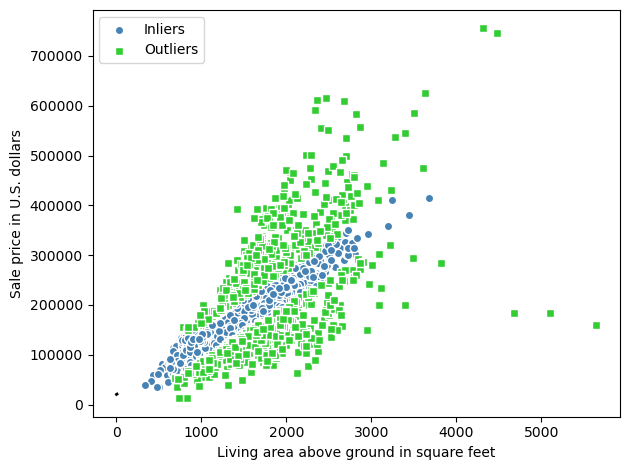

In [310]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### The graph produced shows the inliers as circles (coloured in blue)

### The slope and intercept using RANSAC will differ slightly from the previous models

In [311]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')  

Slope: 106.348


In [312]:
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Intercept: 20190.093


###  Computing  the Median Absolute Deviation (MAD)

In [313]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))
median_absolute_deviation(y)   
    
      

np.float64(37000.0)

### Evaluating the Linear Regression Models for Peformance

#### For the evaluation, the dataset will be split into separate training and test datasets- the former to fit the model, the latter to evaluate its performance on unseen/untested data. All five feautures in the dataset will now be used in this process.

In [314]:
from sklearn.model_selection import train_test_split
target = 'SalePrice' 
features = df.columns[df.columns !=target] 
X = df[features].values 
y = df[target].values 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)
slr = LinearRegression() 
slr.fit(X_train, y_train) 
y_train_pred  = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

### Visualization: Because this model uses multiple explanatory variables, we can't vizualize the regression in a 2-D plot. Instead the residuals (deltas or vertical distances between the actual and predicted values) versus the predicted values to evaluate the regression model.

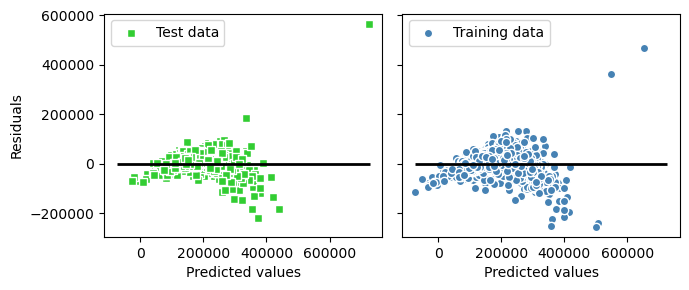

In [315]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

plt.show()



#### Notes on the Residual Plots: A theoretically perfect prediction would have residual values of zero, which are likely never to be observed in actual analyses. 

## Some Indices for evaluating regression models:
### General goals / use cases for Residual Plots include the expectation that in a "good" regression model, errors are expected to dislplay a random distribution, with the residuals randdomly scattered around the centerline. 

<ul><li>Patterns in residual plots indicate that the model is unable to capture some explanatory information (which has leaked into the residuals).</li>
<li>Residual plots can be used to identify outliers in the data, which are displayed as data points having a large deviation from the centerline</li></ul>

## MEAN SQUARED ERROR 

### Notes on MSE(Mean Squared Error) as a measure for Model Performance 

### MSE also normalizes according to the sample size, n. This faciliates comparisons across different sample sizes.

In [318]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.2f}')
print(f'MSE test: {mse_test:.2f}')



MSE train: 1497216245.85
MSE test: 1516565821.00


#### Notes on the MSE error analysis: The resulting MSE on the training dataset is less than for the test set (MSE_train < MSE_test). This indicates that the model is overfitting the training data slightly in this instance.

### Mean Absolute Error (MAE) method

#### To display  the error for the orgiginal unit scale (in this case US Dollars instead of US Dollars Squared), the MAE will miminmize the incorrect predcttion slightly less.

In [320]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

MAE train: 25983.03
MAE test: 24921.29


### Notes on MAE results: The model is making an error of approximatly $25,000 USD on average.

#### Comments on MSE / MAE results: It is important to note that in contrast to the classification accuracy, the MAE and MSE are unbounded. This means that interpreting these results is dependent on the dataset and feature scaling. E.g., If the Sale prices were presenteda as multiples of 1,000, the same model would yield a *LOWER* MAE compared to a model that worked with unscaled features.

#### For this reason it may be useful to report the Coefficent of Determination (R^2), a standardized version of the MSE for better interpretability of the model's performance.

### R^2  = 1 - (SSE/SST)   where SSE is the sum of squared errors (without the normalization), and SST is the total sum of squares. SST is the variance of the response.


In [322]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

R^2 train: 0.769, 0.752


### Notes on the R^2 results:  R^2 on the training dataset was bounded between 0 an 1, but it can become negative for the test dataset, which would mean that the regression model fits worse than the sample mean(represented by te horizontal line in the residual plots). This can happen in cases of extreme overfitting, or if the scaling for the test set dffers from the training set.

### With the R^2 values of 0.769 (0.77) vs. the 0.75 for the training and test sets respectively, the overfitting observed only appears to be slight.

# Using Regularized (i.e. minimized squared residual sums, plus a penalty term) Methods for Regression

### Ridge Regression, LASSO (Least Absolute Shrinkage and Selector Operator), and Elastic Net will be used

### Regularization penalizes high-valued regression coefficients.
<ul><li>L1 (LASSO) Regularization adds a penalty to the absolue value of the coefficients magnitude.</li>
<li>L2 (Ridge) Regularization adds a penalty equal to the square of the magnitude of the coefficients</li>

## Comparisons L1 and L1 Regularization
<ul>L1<li>Sum of abs value of weights</li>                      
<li>Sparse solution outcomes</li>                               
<li>Multiple solutions possible</li>                            
<li>Built-in fetuare selection in the penalty term</li>         
<li>Robust outliers</li>                                        
<li>Used in datasets with sparse features</li>
</ul>      

<ul>L2</li>
<li>Sum of square of weights</li>   
<li>Non-sparse (more segregated) solution</li>   
<li>Only one solution</li>  
<li>No specific mechanism for feature selection</li>   
<li>Not roubust to outliers (due to square term)</li>  
<li>Used in datasets with complex features</li>
</ul>

#### LASSO: Can be used to handle cases when predictor values are highly corellated, which can result in Multicollinearity problems. This method introduces some bias to reduce the variance. Depending on the regularization strength, certain weights can become zero.

In [346]:
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[26251.38276394   804.70816337    41.94651964 11364.80761309
    55.67855548]


In [347]:
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {train_mse:.3f}, test: {test_mse:.3f}')

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f'R^2 train: {train_r2:.3f}, {test_r2:.3f}')

MSE train: 1497216262.014, test: 1516576825.348
R^2 train: 0.769, 0.752


### Ridge Regression Technique adds thte squared sum of the weights to the MSE loss function

In [349]:
ridge = Ridge(alpha=1.0)

### Elastic Net, is a compromise between LASSO and Ridge, and uses an L1 penalty to generate sparsity and an L2 penalty such that it can be used for selecting more than n features if m > n.

In [348]:
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

## Notes: if L1 is set to ration 1:0, the ElasticNet regressor would equal the LASSO regresion.

## Turning a Linear Regression Model into a Curve -polynomial terms w scikitlearn

In [330]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])


In [331]:
lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

In [332]:
## notes on simple linear regression for comparison

In [333]:
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

In [334]:
## note on mult regression model for comparison

In [335]:
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

In [336]:
### plots 

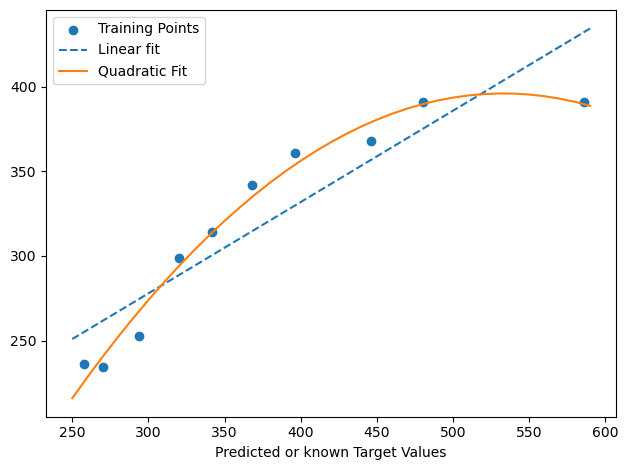

In [337]:
plt.scatter(X, y, label='Training Points') 
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic Fit')
plt.xlabel('Predicted or known Target Values')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [338]:
## notes on computing MSE and R^2 for evaluation metrics

In [339]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad) 

mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')


Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


In [340]:
## Notes on Modeling Nonlinear Relationships in the dataset

In [341]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]


In [342]:
### notes on fitting the regression models

In [353]:

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[(df['Gr Liv Area'] < 4000)]
y = y[(df['Gr Liv Area'] < 4000)]



regr = LinearRegression()

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


## plotting the results

FileNotFoundError: [Errno 2] No such file or directory: 'figures/09_13.png'

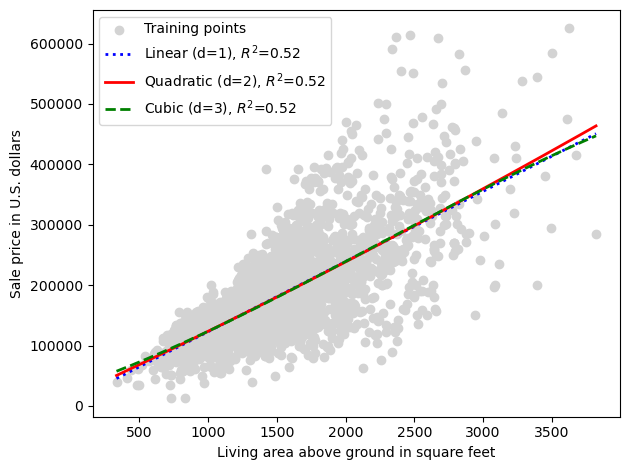

In [354]:
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/09_13.png', dpi=300)
plt.show()



In [ ]:
### notes on overall quality explain below

In [ ]:
# X = df[['Overall Qual']].values
## y = df['SalePrice'].values

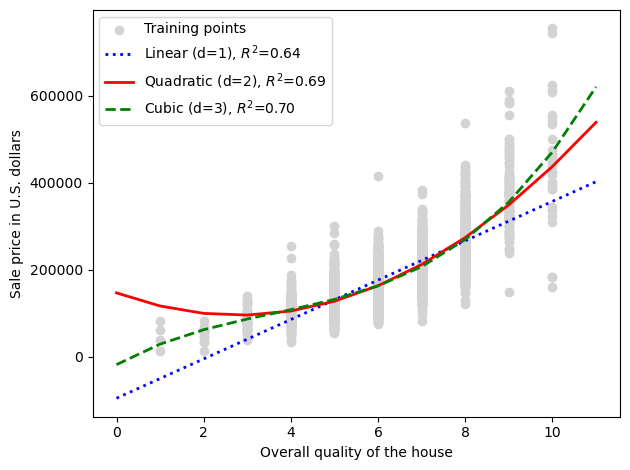

In [355]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values


regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', 
         lw=2,
         linestyle='--')


plt.xlabel('Overall quality of the house')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()

plt.show()

### Handling Nonlinear Relationships using Random Forests

### Decision Tree Regression

### An advantage of Decision Trees is that it works with arbitrary features and doesn't require any feature transformation if the decision trees are nonlinear.Can be used to split the data into its features.

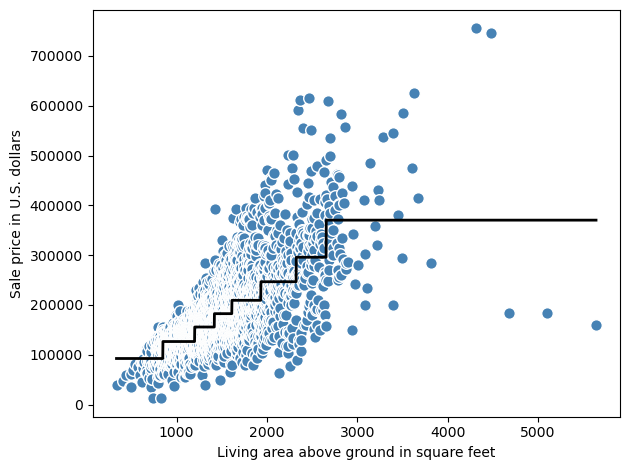

In [356]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values


tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)
sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

plt.tight_layout()
plt.show()

In [357]:
tree_r2 = r2_score(y, tree.predict(X)) 
tree_r2

0.5144569334885711

### Random Forest Regression


### Uses multiple decision trees, they use MSE criterion to grow the individual trees. Usually has better generalization performance compared to an indvidual decision tree due to randomness, which helps decrease the model's variance.

#### A random forest is a meta estimator that fits a number of decision tree regressors on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.Trees use the best split stragety,applying splitter="best" to the underlyin DecisionTreeRegressor.

In [361]:
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

In [362]:


from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='squared_error', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)


mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')



MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


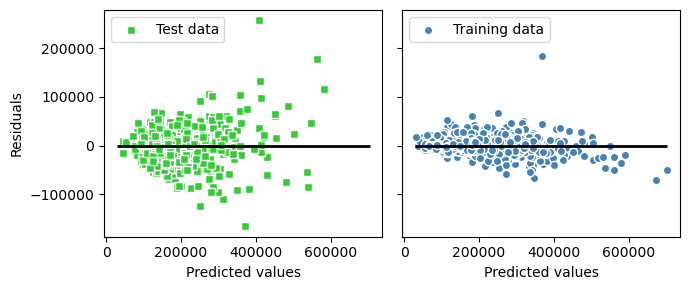

In [363]:

x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

plt.show()



### Notes: The random forest tends to overfit the training data, yet still explains the relationship between the target and explanatory variables well (R^2 = 0.85). When compared to the linear models, they performed worse on the test set (R^2 = 0.75).

### Overall the plots show better fit for the training data versus the test data (indicated by the outliers) in the y-axis. The residuals distribution does not appear to be completely random around the zero point however, indicating that the model is unable to capture all the explanatory information. The residual plot does indicate, however, a large improvement over the previous residual plot from the linear model show in earlier steps. 

### Ideally the model error should be random or unpredictable (not related to any of the information contained in the explanatory variables). A common reason for this can be due to leakage of the explanatory information into the residuals. 